              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       123
         1.0       0.63      0.54      0.58        83

    accuracy                           0.69       206
   macro avg       0.68      0.67      0.67       206
weighted avg       0.68      0.69      0.68       206

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


D:\awrDATEN\lena\python\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
423 fits failed with the following error:
Traceback (most recent call last):
  File "D:\awrDATEN\lena\python\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\awrDATEN\lena\python\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "D:\awrDATEN\lena\python\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit

Beste Parameter: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Bestes F1-Score: 0.6097359238557525
              precision    recall  f1-score   support

         0.0       0.81      0.47      0.59       123
         1.0       0.51      0.83      0.64        83

    accuracy                           0.62       206
   macro avg       0.66      0.65      0.62       206
weighted avg       0.69      0.62      0.61       206

Confusion Matrix:
[[58 65]
 [14 69]]


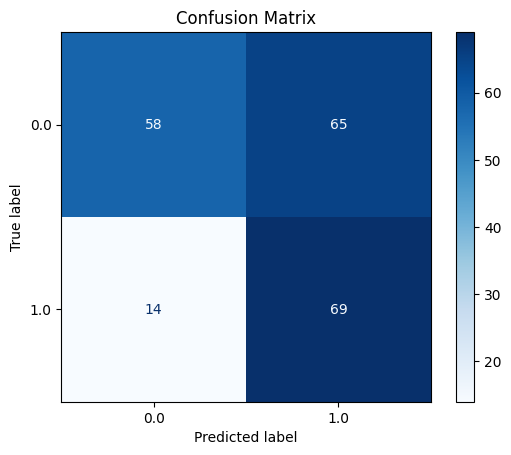

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split #Daten in Trainings- und Testdaten werden  aufgeteilt. Das ist wichtig, um später objektiv zu überprüfen, wie gut das Modell generalisiert.
from sklearn.pipeline import Pipeline #Pipeline erlaubt, mehrere Schritte (z. B. Vorverarbeitung + Modelltraining) sauber zusammenzufassen.
from sklearn.preprocessing import OneHotEncoder, StandardScaler #StandardScaler: Skaliert numerische Werte (Mittelwert 0, Standardabweichung 1),OneHotEncoder: Wandelt Kategorien  in numerische Spalten (Dummy-Variablen) um.
from sklearn.compose import ColumnTransformer #erlaubt unterschiedliche Vorverarbeitung für numerische und kategoriale Spalten anzuwenden.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

# Custom Transformer zur Umwandlung von Author_Rating in Zahlen
class AuthorRatingMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.rating_map = {
            "Novice": 1,
            "Intermediate": 2,
            "Famous": 3,
            "Excellent": 4
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if 'Author_Rating' in X.columns:
            X['Author_Rating'] = X['Author_Rating'].map(self.rating_map)
        return X
##########################################################
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report # du eine Auswertung des Modells: Genauigkeit, Präzision, Recall, F1-Score – für beide Klassen (verfilmt / nicht verfilmt).
##########################################################
# Bereinigte Datei laden
df = pd.read_csv("book_data_clean.csv", sep=";", encoding="utf-8")
# Ziel & Features
y = df['Adapted_to_Film']# Zielvariable/Label. Das Modell soll lernen, ob ein Buch verfilmt wurde (1) oder nicht (0).
X = df.drop(columns=['Adapted_to_Film', 'Book_Name'])# es wird ZIELspalte entfernt und BOOK_Name , das stört im Model

#Publisher & Autoren gruppieren
top_publishers = X['Publisher'].value_counts().nlargest(10).index #Top 10 Publisher behalten.
X['Publisher'] = X['Publisher'].where(X['Publisher'].isin(top_publishers), other='other')#Alle anderen als "other" gruppiert
top_authors = X['Author'].value_counts().nlargest(10).index
X['Author'] = X['Author'].where(X['Author'].isin(top_authors), other='Sonstige')
# Numerische und kategoriale Features trennen

numerical_features = ['Publishing_Year', 'Author_Rating', 'Average_Rating', 'Rating_Count', 'Gross_Sales_EUR']
categorical_features = ['Language_Code', 'Genre', 'Publisher', 'Author']

#verarbeitung mit ColumnTransformer
#numerical_features: mit StandardScaler skalieren
#categorical_features: mit OneHotEncoder in Dummy-Variablen umwandeln

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])


# Pipeline mit Mapper + Preprocessing + Modell
pipeline = Pipeline(steps=[
    ('author_rating_mapper', AuthorRatingMapper()),
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42,  class_weight={0:1, 1:2}))])

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#Modell trainieren
pipeline.fit(X_train, y_train)#Der Preprocessing-Schritt auf X_train angewendet,  RandomForest-Modell mit den verarbeiteten Daten trainiert

#Vorhersage & Auswertung: mach Vorhersage mit x_test und 
y_pred = pipeline.predict(X_test)#vergleiche Vorhersagey_pred mit echten Werten- y_test
print(classification_report(y_test, y_pred))



from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train, y_train)

print("Beste Parameter:", grid_search.best_params_)
print("Bestes F1-Score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Vorhersagen (du hast y_pred schon)
# y_pred = pipeline.predict(X_test)

# Confusion Matrix berechnen
cm = confusion_matrix(y_test, y_pred)

# Confusion Matrix ausgeben
print("Confusion Matrix:")
print(cm)

# Confusion Matrix visualisieren
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
"""Die genauere Trennung der Klassen hat sich etwas verändert:

Klasse 0 (z.B. „nicht verfilmt“) hat eine hohe Precision (81%), aber niedrigeren Recall (47%). Das heißt, wenn das Modell Klasse 0 vorhersagt, ist es oft richtig — aber es verpasst viele tatsächliche Klasse-0-Fälle (viele False Negatives).

Klasse 1 (z.B. „verfilmt“) wird besser erkannt (Recall 83%), aber mit niedrigerer Precision (51%) — also es sagt öfter Klasse 1, aber nicht immer korrekt (mehr False Positives).

Der F1-Score für Klasse 1 ist mit 0.64 besser als vorher, das ist oft wichtiger, wenn man die „positive“ Klasse gut erkennen will.

Gesamtgenauigkeit ist ca. 62%, etwas weniger hoch als vorher, aber das Modell ist jetzt ausgeglichener im Erkennen der Klassen (je nachdem, was dir wichtiger ist)."""